# LEE Analyzer Data/MC comparison plots


## Imports & Constants

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from itertools import chain
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

from helpfunction import sciNot,sciNot2,effErr,maxscore,minscore,avgscore

%matplotlib inline

pd.options.display.max_columns = 999
gr      = 1.618

mass_p= 0.93827 #GeV
mass_e= 0.00511 #GeV
z_dead_start = 675
z_dead_end=z_dead_start+100
input_dir = "../Input/pandora_pdg_cut/"
output_dir = "../Output/Nue_CC_final/"

In [2]:
catdefs={   1: 'Cosmic',
            2: 'e CC',
            3: 'mu CC',
            4: 'NC',
            5: 'Dirt',
            6: 'Data',
            7: 'Mixed',
            0: 'Other'}

pandora_pdg ={14:False,
              12:True}

def veclencos(row):
    x1 = row["vx"]
    y1 = row["vy"]
    z1 = row["vz"]
    x2 = row["chargecenter_x"]
    y2 = row["chargecenter_y"]
    z2 = row["chargecenter_z"]
    
    x = np.array([x2-x1,y2-y1,z2-z1])
    dist = np.linalg.norm(x)
    cos = np.dot(x,np.array([0,0,1]))/dist
    return pd.Series({"total_len":dist,"total_cos":cos})


def categoryPlus(row):
    label = catdefs[row['category']]
    if row['nu_pdg']==12:
        if label=='e CC':
            return r'$\nu_e$ CC     '
        elif label=='Mixed':
            return r'$\nu_e$ cont.   '
        else:
            return label+' '*(12-len( label))
    
    elif row['nu_pdg']==14:
        if label=='mu CC':
            return r'$\nu_{\mu}$ CC       '
        elif label=='Mixed':
            return r'$\nu_{\mu}$ cont.   '
        else:
            return  label+' '*(12-len( label))
        
    elif row['nu_pdg']==4294967282 or row['nu_pdg']==4294967284:
        return r'$\bar{\nu}_{\mu} / \bar{\nu}_e$          '
    elif row['nu_pdg']==15:
        return 'simulated LEE   '
    else:
        #print (row['nu_pdg'])
        return 'Cosmic intime '
    
# Formatting
def sciNotSpace(x):
    x=float(x)
    return "{:4.1f}".format(x)


#The statistical uncertainity per bin of the binned data.
#If there are weights then the uncertainity will be the root of the
#sum of the weights squared.
def hist_bin_uncertainty(data, weights, bin_edges):
    # Bound the data and weights to be within the bin edges
    in_range_index = [idx for idx in range(len(data)) if data[idx] > min(bin_edges) and data[idx] < max(bin_edges)]
    in_range_data = np.asarray([data[idx] for idx in in_range_index])
    in_range_weights = np.asarray([weights[idx] for idx in in_range_index])

    # Bin the weights with the same binning as the data
    bin_index = np.digitize(in_range_data, bin_edges)
    # N.B.: range(1, bin_edges.size) is used instead of set(bin_index) as if
    # there is a gap in the data such that a bin is skipped no index would appear
    # for it in the set
    binned_weights = np.asarray(
        [in_range_weights[np.where(bin_index == idx)[0]] for idx in range(1, len(bin_edges))])
    bin_uncertainties = np.asarray(
        [np.sqrt(np.sum(np.square(w))) for w in binned_weights])
    return bin_uncertainties

## Load Pickle file

In [3]:
# Used for plots: 
df_nu_test = pd.read_pickle(input_dir+'XGB_out/nu_test0123_xgb.pckl')
df_nue_test = pd.read_pickle(input_dir+'XGB_out/nue_test56789_xgb.pckl')
df_bnb     = pd.read_pickle(input_dir+'XGB_out/bnb_xgb.pckl')
df_bnbext  = pd.read_pickle(input_dir+'XGB_out/bnbext_xgb.pckl')
df_lee     = pd.read_pickle(input_dir+'XGB_out/lee_xgb.pckl')
df_lee['nu_pdg']=15

#Used for training:
df_nu_train  = pd.read_pickle(input_dir+'XGB_out/nu_train4567_xgb.pckl')
df_nue_train = pd.read_pickle(input_dir+'XGB_out/nue_train01234_xgb.pckl')
df_intime_train = pd.read_pickle(input_dir+'XGB_out/intime_xgb.pckl')
df_lee_train = pd.read_pickle(input_dir+'XGB_out/lee_75k_xgb.pckl')
df_lee_train["bnbweight"]=1.5

print('MC BNB nu test loaded from Pickle has '+str(len(df_nu_test.index))+' entries.' )
#print('MC BNB nue test loaded from Pickle has '+str(len(df_nue_test.index))+' entries.' )
#print('MC BNB nu train loaded from Pickle has '+str(len(df_nu_train.index))+' entries.' )
#print('MC BNB nue train loaded from Pickle has '+str(len(df_nue_train.index))+' entries.' )


# POT for the BNB nu test set file 0-3
pot_this = (
      3.268803486357006e+20+
      3.275377418388517e+20+
      3.2636240240463466e+20+
      3.2694485860610775e+20
     )
total_data_bnb_pot = 3.918e+19 #4.232e19
total_data_pot     = 6.6e+20
lee_pot = 2.39861815e+21
scale_ext= 0.157#0.17

pot_ratio1 = pot_this/total_data_bnb_pot
pot_ratio2 = pot_this/total_data_pot

MC BNB nu test loaded from Pickle has 37525 entries.


In [4]:
dfs = [df_nu_test,df_lee,df_nu_train,df_nue_train,df_intime_train,df_lee_train,df_nue_test]
for df in dfs:
    df['catplus']=df.apply(categoryPlus,axis=1)
    df['pandora_pdg'] = df['candidate_pdg'].map(pandora_pdg)
    df["reconstructed_energy"] = df.apply(lambda x: sum(x["track_energy_w"])+sum(x["shower_energy_w"]),axis=1) 
    df["dead_collection"] = ~df['vz'].between(z_dead_start,z_dead_end)
    df["E/PE"] = df["reconstructed_energy"] / df["flash_PE_max"]*1000
    dftemp = df.apply(veclencos,axis=1)
    df["total_len"] = dftemp["total_len"]
    df["total_cos"] = dftemp["total_cos"]
    
dfs_data = [df_bnb,df_bnbext]
for df in dfs_data:
    df['pandora_pdg'] = df['candidate_pdg'].map(pandora_pdg)
    df["reconstructed_energy"] = df.apply(lambda x: sum(x["track_energy_w"])+sum(x["shower_energy_w"]),axis=1) 
    df["dead_collection"] = ~df['vz'].between(z_dead_start,z_dead_end)
    df["E/PE"] = df["reconstructed_energy"] / df["flash_PE_max"]*1000
    dftemp = df.apply(veclencos,axis=1)
    df["total_len"] = dftemp["total_len"]
    df["total_cos"] = dftemp["total_cos"]
    
df_nu_test = df_nu_test[df_nu_test["dead_collection"]==1]
df_lee = df_lee[df_lee["dead_collection"]==1]
df_nu_train = df_nu_train[df_nu_train["dead_collection"]==1]
df_nue_test = df_nue_test[df_nue_test["dead_collection"]==1]
df_nue_train = df_nue_train[df_nue_train["dead_collection"]==1]
df_intime_train = df_intime_train[df_intime_train["dead_collection"]==1]
df_lee_train = df_lee_train[df_lee_train["dead_collection"]==1]

df_bnb = df_bnb[df_bnb["dead_collection"]==1]
df_bnbext = df_bnbext[df_bnbext["dead_collection"]==1]

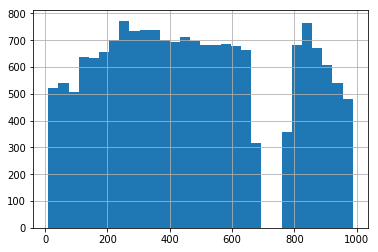

In [5]:
df_nu_train["vz"].hist(bins=30)

## Plots

In [6]:
categories = ['$\\nu_e$ CC     ',
              '$\\nu_{\\mu}$ CC       ',
              '$\\nu_e$ cont.   ',
              '$\\nu_{\\mu}$ cont.   ',
              'NC          ',
              'Cosmic      ',
              'Dirt        ',
              '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$          ',
              
              ]


catlabs = ['$\\nu_e$ CC         ',
              '$\\nu_{\\mu}$ CC       ',
              '$\\nu_e$ cont.    ',
              '$\\nu_{\\mu}$ cont.   ',
              'NC           ',
              'Cosmic    ',
              'Dirt        ',
              '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$     ',]

In [7]:
# Plot of the selected events in true neutrino energy:
df=df_nu_test
entries= len(df.index)

print (categories)
true_E = []
reco_E = [] 
counter= []
labels = []
bnbweight=[]

for cat,catlab in zip(categories,catlabs):
    true_E.append(df[df['catplus']==cat]['nu_E'])
    reco_E.append(df[df['catplus']==cat]['reconstructed_energy'])
    bnbweight.append(df[df['catplus']==cat]['bnbweight'])  
    lab = catlab+ '('+str(     int(round(sum(bnbweight[-1])/pot_ratio2))) +')'
    labels.append(lab)

['$\\nu_e$ CC     ', '$\\nu_{\\mu}$ CC       ', '$\\nu_e$ cont.   ', '$\\nu_{\\mu}$ cont.   ', 'NC          ', 'Cosmic      ', 'Dirt        ', '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$          ']


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


33766
4    8799
3    8310
1    7433
7    6283
5    1736
2    1205
Name: category, dtype: int64


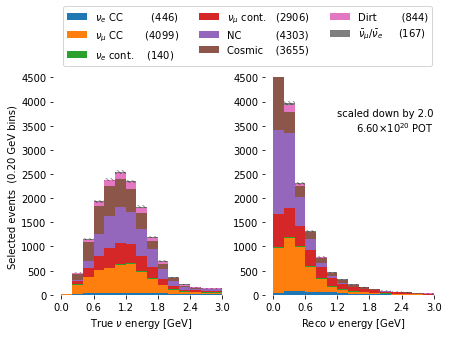

In [8]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4.3*gr,4),sharey=False,sharex=True)
N = 15
min_x = 0.0
max_x = 3.
max_y = 4500
step  = 0.6
binwidth=(max_x-min_x)/N

entries,edges,_ =ax[0].hist(true_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(true_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

entries,edges,_ = ax[1].hist(reco_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  


ax[0].set_ylabel('Selected events  ('+sciNot2(binwidth)+' GeV bins)')
ax[0].set_xlabel(r'True $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[0].set_ylim(0,max_y)
ax[1].set_ylim(0,max_y)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.35))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x,max_y*.75,'scaled down by '+sciNot(pot_ratio2)+"\n"+sciNot2(total_data_pot/1e20)+r'$\times 10^{20}$ POT',horizontalalignment='right')

plt.savefig(output_dir+"BNB_nu_before.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

print(len(df.index))
print(df['category'].value_counts())

In [9]:
def nue_select_manual(row):
    # Reasonable cuts
    if(row["n_tracks"]+row["n_showers"]>4):
        return False
    if(row["total_spacepoint_containment"]<0.95):
        return False
    # Muon cuts
    if(np.any(np.array(row['track_muon_score'])>0.05)):
        return False
    if(np.any(np.array(row['shower_muon_score'])>0.15)):
        return False
    # Electron cuts
    if(np.any(np.array(row['track_electron_score'])>0.9) or np.any(np.array(row['track_closest_electron_score'])>0.9)):
        if(np.any(np.array(row['shower_electron_score'])>0.6)):
            return True
    if(np.any(np.array(row['shower_electron_score'])>0.85)):
        if(np.any(np.array(row['shower_cle_lee_score'])>0.8) or np.any(np.array(row['shower_closest_electron_score'])>0.8)):
            return True
    return False

In [ ]:
# Plot of the selected events in true neutrino energy:

df = df_nu_test[df_nu_test.apply(nue_select_manual, axis=1)]

entries= len(df.index)

true_E = []
reco_E = [] 
counter= []
labels = []
bnbweight=[]

for cat,catlab in zip(categories,catlabs):
    true_E.append(df[df['catplus']==cat]['nu_E'])
    reco_E.append(df[df['catplus']==cat]['reconstructed_energy'])
    bnbweight.append(df[df['catplus']==cat]['bnbweight'])  
    print(cat)
    lab = catlab+ '('+str(     int(round(sum(bnbweight[-1])/pot_ratio2))) +')'
    labels.append(lab)
    
print(sum(bnbweight[0])/pot_ratio2)
print(sum(bnbweight[0])/sum(np.hstack(bnbweight)))

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4.3*gr,4),sharey=False,sharex=True)
N = 15
min_x = 0.0
max_x = 3.
max_y = 55
step  = 0.6
binwidth=(max_x-min_x)/N

entries,edges,_ =ax[0].hist(true_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(true_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

entries,edges,_ = ax[1].hist(reco_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  


ax[0].set_ylabel('Selected events  ('+sciNot2(binwidth)+' GeV bins)')
ax[0].set_xlabel(r'True $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[0].set_ylim(0,max_y)
ax[1].set_ylim(0,max_y)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.35))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x,max_y*.75,'scaled down by '+sciNot(pot_ratio2)+"\n"+sciNot2(total_data_pot/1e20)+r'$\times 10^{20}$ POT',horizontalalignment='right')

plt.savefig(output_dir+"BNB_nu_muanual.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

print(len(df.index))
print(df['category'].value_counts())

# XGBoost $\nu_e$ score

In [ ]:
def addScores(df_all):
    df_all=df_all.copy()
    df_all['tr_mu_max']=df_all['track_muon_score'].apply(maxscore)
    df_all['tr_mu_avg']=df_all['track_muon_score'].apply(avgscore)
    df_all['sh_mu_max']=df_all['shower_muon_score'].apply(maxscore)
    df_all['sh_mu_avg']=df_all['shower_muon_score'].apply(avgscore)
    
    
    df_all['tr_e_max_temp']=df_all['track_electron_score'].apply(maxscore)
    mean = df_all['tr_e_max_temp'][df_all['tr_e_max_temp']>0].mean()
    df_all['tr_e_max']=df_all['tr_e_max_temp'].apply(lambda x: mean if x==0 else x)
    
    df_all['sh_e_max_temp']=df_all['shower_electron_score'].apply(maxscore)
    mean = df_all['sh_e_max_temp'][df_all['sh_e_max_temp']>0].mean()
    df_all['sh_e_max']=df_all['sh_e_max_temp'].apply(lambda x: mean if x==0 else x)

    df_all['sh_e_avg']=df_all['shower_electron_score'].apply(avgscore)
    
    df_all['tr_cle_max_temp']=df_all['track_closest_electron_score'].apply(maxscore)
    mean = df_all['tr_cle_max_temp'][df_all['tr_cle_max_temp']>0].mean()
    df_all['tr_cle_max']=df_all['tr_cle_max_temp'].apply(lambda x: mean if x==0 else x)

    df_all['sh_cle_max_temp']=df_all['shower_closest_electron_score'].apply(maxscore)
    mean = df_all['sh_cle_max_temp'][df_all['sh_cle_max_temp']>0].mean()
    df_all['sh_cle_max']=df_all['sh_cle_max_temp'].apply(lambda x: mean if x==0 else x)
    
    df_all['sh_cle_lee_max_temp']=df_all['shower_cle_lee_score'].apply(maxscore)
    mean = df_all['sh_cle_lee_max_temp'][df_all['sh_cle_lee_max_temp']>0].mean()
    df_all['sh_cle_lee_max']=df_all['sh_cle_lee_max_temp'].apply(lambda x: mean if x==0 else x)
    
    df_all['sh_energy']=df_all['shower_energy_w'].apply(lambda x: sum(x))
    
    df_all["n_objects"]=df_all["n_showers"]+df_all["n_tracks"]
    df_all["has_track"]=df_all["n_tracks"]>0
    return df_all

In [ ]:
df_nue_train.head()

In [ ]:
columns_train = ['tr_mu_max','sh_mu_max',
                 'sh_e_max','sh_cle_max',"sh_cle_lee_max",
                 'tr_cle_max',
                 "total_spacepoint_containment","numu_cuts","has_track",
                 "vtx_activity_nr","reconstructed_energy",
                 'sh_e_avg',#"tr_mu_avg",'sh_mu_avg'
                 "total_len","total_cos"
                ]
#columns_train = ['tr_mu_max','sh_mu_max','sh_e_avg','tr_cle_max','sh_cle_max']

df_train = pd.concat([df_intime_train,df_nu_train,df_nue_train,df_lee_train],ignore_index=True,copy=True)

df_train   = addScores(df_train)
df_nu_test = addScores(df_nu_test)

print(df_train.columns)
X_train = df_train[columns_train].as_matrix()
y_train = df_train['catplus']=='$\\nu_e$ CC     '
y_train_weights = df_train['bnbweight']

X_test = df_nu_test[columns_train].as_matrix()
y_test = df_nu_test['catplus']=='$\\nu_e$ CC     '
y_test_weights = df_nu_test['bnbweight']

In [ ]:
# fit model no training data
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

model = XGBClassifier()
model.fit(X_train, y_train,sample_weight=y_train_weights)
print(classification_report(y_test, model.predict(X_test)))
y_pred = model.predict_proba(X_test)

joblib.dump(model, input_dir+'XGBoost/model_nue.pkl') 

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_train)):
    print("%d. feature %s(%f)" % (f + 1, columns_train[indices[f]],importances[indices[f]]))

In [ ]:
plt.style.use('default')
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(3*gr,5),sharex=True)
plt.suptitle(r'XGBoost $\nu_e$ CC classifier (test dataset)')
N=50

nue_cut=0.87
# Electron track classification
arr_e  = y_pred[y_test==1][:,1]
arr_ne = y_pred[y_test==0][:,1]
arr_e_weigths  = y_test_weights[y_test==1]
arr_ne_weigths  = y_test_weights[y_test==0]


label_e=(r'$\nu_e$ CC ('+str(int(sum(arr_e_weigths)))+')','Other ('+str(int(sum(arr_ne_weigths)))+')')

ax.axvspan(nue_cut,0, alpha=0.15, color='red',label='_nolegend_')
ax.axvspan(nue_cut,1, alpha=0.15, color='green',label='Accepted events > '+str(nue_cut) )
ax.hist([arr_e,arr_ne],weights= [arr_e_weigths,arr_ne_weigths],  histtype='step', bins=N, fill=False,label=label_e,density=True)
ax.set_ylabel('Normalised')
ax.set_xlabel(r'$\nu_e$ XGB probability')

#ax[1].axvspan(nue_cut,0, alpha=0.15, color='red',label='_nolegend_')
#ax[1].axvspan(nue_cut,1, alpha=0.15, color='green',label='Accepted events > '+str(nue_cut) )
#ax[1].hist([arr_e,arr_ne],weights= [arr_e_weigths,arr_ne_weigths],histtype='step', bins=N, fill=False,label=label_e,density=True)
#ax[1].set_ylim(0,5.4)
#ax[1].set_xlabel(r'$\nu_e$ XGB probability')
#ax[1].axvline(x=nue_cut,alpha=.2,color='k',label='Proposed cut: '+str(nue_cut))

#offset=0.05
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],loc='upper center')

plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig(output_dir+'XGB_nue.pdf')

print('Cut value:',nue_cut,'keeps', sciNot(sum(arr_e>nue_cut) / len(arr_e)*100),'% of nue CC events and',
      sciNot2(sum(arr_ne>nue_cut) / len(arr_ne)*100),'% of background events.')

In [ ]:
df_nu_test['nue_predict'] = y_pred[:,1]

In [ ]:
df_nu_test['nue_predict'].mean()
nue_cut=0.87

In [ ]:
# Plot of the selected events in true neutrino energy:

df = df_nu_test[df_nu_test['nue_predict']>nue_cut]
entries= len(df.index)

true_E = []
reco_E = [] 
counter= []
labels = []
bnbweight=[]

for cat,catlab in zip(categories,catlabs):
    true_E.append(df[df['catplus']==cat]['nu_E'])
    reco_E.append(df[df['catplus']==cat]['reconstructed_energy'])
    bnbweight.append(df[df['catplus']==cat]['bnbweight'])  
    print(cat)
    lab = catlab+ '('+str(     int(round(sum(bnbweight[-1])/pot_ratio2))) +')'
    labels.append(lab)

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4.3*gr,4),sharey=False,sharex=True)
N = 15
min_x = 0.0
max_x = 3.
max_y = 80
step  = 0.6
binwidth=(max_x-min_x)/N

entries,edges,_ =ax[0].hist(true_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(true_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

entries,edges,_ = ax[1].hist(reco_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  


ax[0].set_ylabel('Selected events  ('+sciNot2(binwidth)+' GeV bins)')
ax[0].set_xlabel(r'True $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[0].set_ylim(0,max_y)
ax[1].set_ylim(0,max_y)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.3))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x,max_y*.75,'scaled down by '+sciNot(pot_ratio2)+"\n"+sciNot2(total_data_pot/1e20)+r'$\times 10^{20}$ POT',horizontalalignment='right')

plt.savefig(output_dir+"BNB_nu_xgb.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

print(len(df.index))
print(df['catplus'].value_counts())

# Data Monte Carlo

In [ ]:
df_bnb   = addScores(df_bnb)
df_bnbext = addScores(df_bnbext)
df_lee = addScores(df_lee)
df_intime_train= addScores(df_intime_train)

df_bnb['nue_predict']    = model.predict_proba(df_bnb[columns_train].as_matrix())[:,1]
df_bnbext['nue_predict'] = model.predict_proba(df_bnbext[columns_train].as_matrix())[:,1]
df_lee['nue_predict'] = model.predict_proba(df_lee[columns_train].as_matrix())[:,1]
df_intime_train['nue_predict'] = model.predict_proba(df_intime_train[columns_train].as_matrix())[:,1]

df_bnb["nue_manual"] = df_bnb.apply(nue_select_manual, axis=1)
df_bnbext["nue_manual"] = df_bnbext.apply(nue_select_manual, axis=1)
df_lee["nue_manual"] = df_nu_test.apply(nue_select_manual, axis=1)
df_intime_train["nue_manual"] = df_lee.apply(nue_select_manual, axis=1)
df_nu_test["nue_manual"] = df_nu_test.apply(nue_select_manual, axis=1)

nue_method = "nue_predict"

In [ ]:
print("Amount of LEE events scaled to data:",sum(df_lee[nue_method]>nue_cut)*total_data_bnb_pot/lee_pot)
df_nu_test[df_nu_test[nue_method]>nue_cut]['n_showers'].hist(range=(-0.5,5.5),bins=6)

events_str = []

events_str.append( "run==5161 & subrun==8 & event==447" )    # nue, 2 showers, 1 track
events_str.append( "run==5906 & subrun==74 & event==3710" )  # nue, 1 shower, 1 track (together with Brooke)
events_str.append( "run==5513 & subrun==0 & event==31" )     # nue, 3 showers (together with Roberto)
events_str.append( "run==5328 & subrun==30 & event==1515" )  # nue, 3 showers (together with Roberto)
events_str.append( "run==5761 & subrun==11 & event==582" )   # nue, track not reconstructed, electron is track+shower

events_str.append( "run==5187 & subrun==182 & event==9135" ) # Single shower

#events_str.append( "run==5332 & subrun==19 & event==963" )   # low energy electron, probably michel

#events_str.append( "run==5914 & subrun==49 & event==2467" )  # nue or pi0
#events_str.append( "run==5508 & subrun==90 & event==4517" )  # probably piO
#events_str.append( "run==5382 & subrun==166 & event==8307" ) # probably pi0
#events_str.append( "run==5266 & subrun==6 & event==350" )    # probably single photon

query_str_candles = " or ".join(events_str)

df_bnb.query(query_str_candles).head(len(events_str))

In [ ]:
# For MC
#['tr_mu_max','sh_mu_max','tr_e_max','sh_e_max','sh_e_avg','tr_cle_max','sh_cle_max']

df_before = df_nu_test.copy()
df_after  = df_nu_test[df_nu_test[nue_method]>nue_cut].copy()

nue_score_before = []
tr_mumax_score_before = []
reco_E_before = [] 
labels_before = []
bnbweight_before =[]

reco_E_after = [] 
labels_after = []
bnbweight_after =[]

catlabs = ['$\\nu_e$ CC        ',
              '$\\nu_{\\mu}$ CC        ',
              '$\\nu_e$ cont.     ',
              '$\\nu_{\\mu}$ cont.    ',
              'NC            ',
              'Cosmic    ',
              'Dirt         ',
              '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$       ']

for cat,catlab in zip(categories,catlabs):
    nue_score_before.append(df_before[df_before['catplus']==cat][nue_method])
    tr_mumax_score_before.append(df_before[df_before['catplus']==cat]['sh_cle_max'])
    
    reco_E_before.append(df_before[df_before['catplus']==cat]['reconstructed_energy'])
    reco_E_after.append(df_after[df_after['catplus']==cat]['reconstructed_energy'])
    
    bnbweight_before.append(df_before[df_before['catplus']==cat]['bnbweight']) 
    bnbweight_after.append(df_after[df_after['catplus']==cat]['bnbweight'])

    lab = catlab+ '('+str(     int(round(sum(bnbweight_after[-1])/pot_ratio1))) +')'
    labels_before.append(lab)
    lab = catlab+ '('+sciNot(sum(bnbweight_after[-1])/pot_ratio1) +')'
    labels_after.append(lab)
    
print([len(x)/pot_ratio1 for x in reco_E_before])
print([len(x)/pot_ratio1 for x in reco_E_after])

In [ ]:
# for DATA

df_data = [df_bnb.copy(),df_bnbext.copy(),df_lee.copy()]

data_nue_score_before = []
data_tr_mumax_score_before = []

data_reco_E_before    = [] 
data_reco_E_after     = [] 


for index,df in enumerate(df_data):
    
    df_before = df
    df_after = df[df[nue_method]>nue_cut]

    data_nue_score_before.append(df_before[nue_method])
    data_tr_mumax_score_before.append(df_before['tr_cle_max_temp'])
    
    data_reco_E_before.append(df_before['reconstructed_energy'])
    data_reco_E_after.append(df_after['reconstructed_energy'])
    
print([len(x) for x in data_reco_E_before])
print([len(x) for x in data_reco_E_after])


In [ ]:
df_bnb[df_bnb[nue_method]>nue_cut][["run","subrun","event"]].to_csv("data_passed_final_20.csv",index=False)
print(len(df_bnb[df_bnb[nue_method]>0.85].index))
print(len(df_nu_test[df_nu_test[nue_method]>nue_cut].index)/33.4)
print(len(df_bnbext[df_bnbext[nue_method]>nue_cut].index)*0.17)
df_bnb[df_bnb[nue_method]>nue_cut][["event","reconstructed_energy"]].head(30)
#df_bnb[df_bnb[nue_method]>nue_cut]["total_cos"].hist()

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 12
min_x = 0.0
max_x = 2.4
step  = 0.6
y_max1 = 1900
y_max2 = 9.5
binwidth=(max_x-min_x)/N
binhalf=binwidth/2

lower,edges,_ = ax[0].hist(np.array(data_reco_E_before[1]),weights=[scale_ext]*len(data_reco_E_before[1]) ,bins=N, range=(min_x,max_x), fill=True,histtype='step',alpha = 0.4, color= 'k')
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(labels_after,reco_E_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=1.0)
    lower+= lower_this
    
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_reco_E_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+binhalf, bins, xerr=binhalf, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
ax[0].text(max_x,y_max1*.7, 'Data: '+str(len(data_reco_E_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events",horizontalalignment='right')
    
    
    
lower,edges,_= ax[1].hist(np.array(data_reco_E_after[1]),weights=[scale_ext]*len(data_reco_E_after[1]),bins=N, range=(min_x,max_x), fill=True,histtype='step',label='BNB ext    '+ '('+sciNot(len(data_reco_E_after[1])*scale_ext) +')',alpha = 0.4, color= 'k')
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext

for lab,arr,weights in zip(labels_after,reco_E_after,bnbweight_after):
    lower_this,_,_ = ax[1].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,label=lab,bottom=lower,alpha=1.0)
    lower+=lower_this

    
lower_lee,_,_= ax[1].hist(np.array(data_reco_E_after[2]),weights=[total_data_bnb_pot/lee_pot]*len(data_reco_E_after[2]),bins=N, 
                          range=(min_x,max_x), fill=True,stacked=False,label='LEE signal '+ '('+sciNot(len(data_reco_E_after[2])*total_data_bnb_pot/lee_pot) +')',
                          color= 'C0',bottom=lower,alpha=0.7)
lower+=lower_lee
err_lee = np.sqrt(lower_lee/total_data_bnb_pot*lee_pot)*total_data_bnb_pot/lee_pot

mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E_after)), list(chain.from_iterable(bnbweight_after)),edges)
for err,entry,bin_start,err_cos,err_le in zip(mc_err,lower,edges[:-1],err_bnbext,err_lee):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2 + err_le**2 )
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    
bins,edges = np.histogram(data_reco_E_after[0],N, range=(min_x,max_x))
ax[1].errorbar(edges[:-1]+binhalf, bins, xerr=binhalf, yerr=np.sqrt(bins),alpha=0.8, color= 'k',fmt='.')

print(bins)

ax[0].set_ylabel('#Events ('+sciNot2(binwidth)+' GeV bins )')
ax[0].set_xlabel(r'Reconstructed $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reconstructed $\nu$ energy [GeV]')
ax[0].set_ylim(1,y_max1)
ax[1].set_ylim(0,y_max2)
ax[0].set_xlim(0,max_x)
ax[1].set_xlim(0,max_x)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.32))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x+0.1,y_max2*.66, 'Data: '+str(len(data_reco_E_after[0]))+' events'+"\nMC+BNB ext: "+sciNot(sum(lower)-1.6)+'events\n'+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')


plt.savefig(output_dir+"data_mc.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)


In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4.7),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 15
min_x = 0.0
max_x = 1.
step  = 0.2
y_max1 = 2000
y_max2 = 2.0
binwidth=(max_x-min_x)/N


    
lower=np.zeros(N)
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext

for lab,arr,weights in zip(catlabs,nue_score_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=0.8,label=lab)
    lower+= lower_this
lower_this,edges,_ = ax[0].hist(np.array(data_nue_score_before[1]),weights=[scale_ext]*len(data_nue_score_before[1]) ,bins=N, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,label='BNB ext ',alpha = 0.2, color= 'k')
lower+= lower_this
    
mc_err = hist_bin_uncertainty(list(chain.from_iterable(nue_score_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_nue_score_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+binwidth/2, bins, xerr=binwidth/2, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
ax[0].text(1,500, 'Data: '+str(len(data_nue_score_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events"+"\n"+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')

print("data",sum(bins))
print("MC+ext",sum(lower))
print("data/MC",sum(bins)/sum(lower))   
ax[1].errorbar(edges[:-1]+binwidth/2, bins/lower, xerr=binwidth/2, yerr=np.sqrt(bins)/lower,alpha=1.0, color= 'k',fmt='.',label = 'BNB data')
#ax[1].axhline(y=1) 
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)/entry
    if err == mc_err[0]:
        ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4,label='Monte Carlo uncertainty'))
    ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    
ax[1].axvline(x=nue_cut,alpha=.2,color='k',label='Proposed cut: '+str(nue_cut))

ax[0].set_yscale("log", nonposy='clip')
ax[0].set_ylabel('#Events per bin')
ax[0].set_xlabel(r'$\nu_e$ XGB probability')
ax[0].set_ylim(1,y_max1)
ax[1].set_ylim(0,y_max2)

ax[1].set_ylabel('Data/ Monte Carlo')
ax[1].set_xlabel(r'$\nu_e$ XGB probability')

plt.xticks(np.arange(min_x,max_x+step, step))
ax[0].legend(ncol=3,loc='upper center',bbox_to_anchor=(0.52, 1.35))
ax[1].legend(loc='upper left',bbox_to_anchor=(0.25, 1.35))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

plt.tight_layout(w_pad=3.)
plt.savefig(output_dir+"data_mc_score.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)


In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4.7),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 15
min_x = 0.0
max_x = 1.
step  = 0.2
y_max1 = 2000
y_max2 = 1.0
binwidth=(max_x-min_x)/N

lower=np.zeros(N)
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(catlabs,nue_score_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=0.8,label=lab)
    lower+= lower_this
lower_this,edges,_ = ax[0].hist(np.array(data_nue_score_before[1]),weights=[scale_ext]*len(data_nue_score_before[1]) ,bins=N, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,label='BNB ext ',alpha = 0.2, color= 'k')
lower+= lower_this

mc_err = hist_bin_uncertainty(list(chain.from_iterable(nue_score_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_nue_score_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+binwidth/2, bins, xerr=binwidth/2, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
ax[0].text(1,500, 'Data: '+str(len(data_nue_score_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events"+"\n"+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')
#+"\n\n"+'MC scaled down by '+sciNot(pot_ratio1)

nu_e_CC,_ = np.histogram(nue_score_before[0],N,weights=bnbweight_before[0], range=(min_x,max_x))
mc_total  = lower*pot_ratio1
cum_nue = np.cumsum(nu_e_CC[::-1])[::-1] 
cum_tot = np.cumsum(mc_total[::-1])[::-1] 
cum_nue_eff=cum_nue/cum_nue[0]

ax[1].axvline(x=nue_cut,alpha=.2,color='k',label='Proposed cut: '+str(nue_cut))
ax[1].errorbar(edges[:-1], cum_nue_eff, xerr=binwidth/2, yerr=effErr(cum_nue,cum_nue[0]),alpha=1.0, fmt='.',label='Efficiency  (32.6%)')
ax[1].errorbar(edges[:-1], cum_nue/cum_tot, xerr=binwidth/2, yerr=effErr(cum_nue,cum_tot),alpha=1.0, fmt='.',label='Purity      (33.5%)')
ax[1].legend(loc='upper left',bbox_to_anchor=(0.3, 1.1))

ax[0].set_yscale("log", nonposy='clip')
ax[0].set_ylabel('#Events per bin')
ax[0].set_xlabel(r'$\nu_e$ XGB probability')
ax[0].set_ylim(1,y_max1)
ax[1].set_ylim(0,y_max2)

ax[1].set_xlabel(r'$\nu_e$ XGB probability')

plt.xticks(np.arange(min_x,max_x+step, step))
ax[0].legend(ncol=3,loc='upper center',bbox_to_anchor=(0.52, 1.35))
ax[1].legend(loc='upper left',bbox_to_anchor=(0.25, 1.35))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

plt.tight_layout(w_pad=3.)
plt.savefig(output_dir+"eff_pur_score.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)



In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 20
min_x = 0.0
max_x = 1.
step  = 0.2
y_max1 = 25000
y_max2 = 1.5
binwidth=(max_x-min_x)/N


    
lower=np.zeros(N)
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(catlabs,tr_mumax_score_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=0.8,label=lab)
    lower+= lower_this
lower_this,edges,_ = ax[0].hist(np.array(data_tr_mumax_score_before[1]),weights=[scale_ext]*len(data_tr_mumax_score_before[1]) ,bins=N, range=(min_x,max_x),bottom=lower,stacked=False, fill=True,label='BNB ext ',alpha = 0.2, color= 'k')
lower+= lower_this

mc_err = hist_bin_uncertainty(list(chain.from_iterable(tr_mumax_score_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_tr_mumax_score_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+binwidth/2, bins, xerr=binwidth/2, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
#ax[0].text(0.7,2000, 'Data: '+str(len(data_tr_mumax_score_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events"+"\n\n"+'scaled down by '+sciNot(pot_ratio1)+"\n"+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')
     
print(bins/lower)   
ax[1].errorbar(edges[:-1]+binwidth/2, bins/lower, xerr=binwidth/2, yerr=np.sqrt(bins)/lower,alpha=1.0, color= 'k',fmt='.',label = 'BNB data')
#ax[1].axhline(y=1) 
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)/entry
    if err == mc_err[0]:
        ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4,label='Monte Carlo uncertainty'))
    ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    
ax[0].set_yscale("log", nonposy='clip')
ax[0].set_ylabel('#Events per bin')
ax[0].set_xlabel(r'maximum $e$-shower probability')
ax[0].set_ylim(0.1,y_max1)
ax[1].set_ylim(0,y_max2)

ax[1].set_ylabel('Data/ Monte Carlo')
ax[1].set_xlabel(r'maximum $e$-shower probability')

plt.xticks(np.arange(min_x,max_x+step, step))
ax[0].legend(ncol=3,loc='upper center',bbox_to_anchor=(0.52, 1.25))
ax[1].legend(loc='upper left',bbox_to_anchor=(0.25, 1.2))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

plt.tight_layout(w_pad=3.)
plt.savefig(output_dir+"data_mc_sh_emax.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

# BNB external vs CORSIKA intime:

In [ ]:
total_events_nu = 1977650
total_events_intime = 717741
total_pot_nu = pot_this
intime_scaling = 10.279*(total_events_nu/total_events_intime)*(total_data_bnb_pot/total_pot_nu)

In [ ]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(10,4),sharey=False,sharex=False)

nr_ext = str(int(len(df_bnbext.index)*scale_ext))
nr_intime = str(int(len(df_intime_train.index)*intime_scaling))
N=20

bins,edges = np.histogram(df_bnbext[nue_method],bins=N,weights=np.full(len(df_bnbext.index),scale_ext), range=(0,1))
err_bnbext = np.sqrt(bins/scale_ext)*scale_ext
binhalf=(edges[1]-edges[0])/2
ax[2].errorbar(edges[:-1]+binhalf, bins, xerr=binhalf, yerr=np.sqrt(err_bnbext),alpha=1.0, color= 'k',fmt='.',label='BNB ext (MCC8.8)')
bins,_ ,_= ax[2].hist(df_intime_train[nue_method],bins=edges,weights=np.full(len(df_intime_train.index),intime_scaling),histtype='step',label='Cosmic intime (MCC8.7)',alpha=1.0)
ax[2].set_xlabel(r'$\nu_e$ XGB probability')
ax[2].set_yscale("log", nonposy='clip')
ax[2].set_title(r'$\nu_e$ CC inclusive classifier')
err_intime = np.sqrt(bins/intime_scaling)*intime_scaling
for err,entry,bin_start in zip(err_intime,bins,edges[:-1]):
    ax[2].add_patch(patches.Rectangle( (bin_start, entry-err), binhalf*2, err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    

bins,edges = np.histogram(df_bnbext['flash_PE_max'],bins=N,weights=np.full(len(df_bnbext.index),scale_ext), range=(0,9500))
err_bnbext = np.sqrt(bins/scale_ext)*scale_ext
binhalf=(edges[1]-edges[0])/2
ax[0].errorbar(edges[:-1]+binhalf, bins, xerr=binhalf, yerr=np.sqrt(err_bnbext),alpha=1.0, color= 'k',fmt='.',label='BNB ext (MCC8.8)')
bins,_ ,_ = ax[0].hist(df_intime_train['flash_PE_max'],bins=edges,weights=np.full(len(df_intime_train.index),intime_scaling), range=(0,10000),histtype='step',label='Cosmic intime (MCC8.7)',alpha=1.0)
ax[0].set_xlabel('Photon-electrons')
ax[0].set_yscale("log", nonposy='clip')
ax[0].set_title('Photo-electrons in Flash')
err_intime = np.sqrt(bins/intime_scaling)*intime_scaling
for err,entry,bin_start in zip(err_intime,bins,edges[:-1]):
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-err), binhalf*2, err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

bins,edges = np.histogram(df_bnbext['reconstructed_energy'],bins=N,weights=np.full(len(df_bnbext.index),scale_ext), range=(0,3.))
err_bnbext = np.sqrt(bins/scale_ext)*scale_ext
binhalf=(edges[1]-edges[0])/2
ax[1].errorbar(edges[:-1]+binhalf, bins, xerr=binhalf, yerr=np.sqrt(err_bnbext),alpha=1.0, color= 'k',fmt='.',label='BNB ext (MCC8.8)')
bins,_ ,_ = ax[1].hist(df_intime_train['reconstructed_energy'],bins=edges,weights=np.full(len(df_intime_train.index),intime_scaling), range=(0,2),histtype='step',label='Cosmic intime (MCC8.7)',alpha=1.0)
ax[1].set_xlabel('reco E [GeV]')
ax[1].set_yscale("log", nonposy='clip')
ax[1].set_title('Reconstructed energy')
err_intime = np.sqrt(bins/intime_scaling)*intime_scaling
for err,entry,bin_start in zip(err_intime,bins,edges[:-1]):
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-err), binhalf*2, err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ax[0].set_ylabel('Events per bin')
ax[0].text(9498,100, "Scaled to "+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT'+"\n\n"+
           'Data: '+nr_ext+' events'+"\nMC: "+nr_intime+' events'
           ,horizontalalignment='right')
ax[1].legend()

ax[0].set_ylim(1,900)
ax[1].set_ylim(1,900)
ax[2].set_ylim(1,900)

plt.tight_layout(w_pad=1.)
plt.savefig(output_dir+"intime.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)